# <center>ASTR4004/8004 - Neural Networks - Part 4</center>

This notebook builds autoencoders to generate handwritten digits.

We will train the network using handwritten digits from the Modified National Institute of Standards and Technology database (i.e., [MNIST dataset](http://yann.lecun.com/exdb/mnist/)), and construct the following architecture for our network

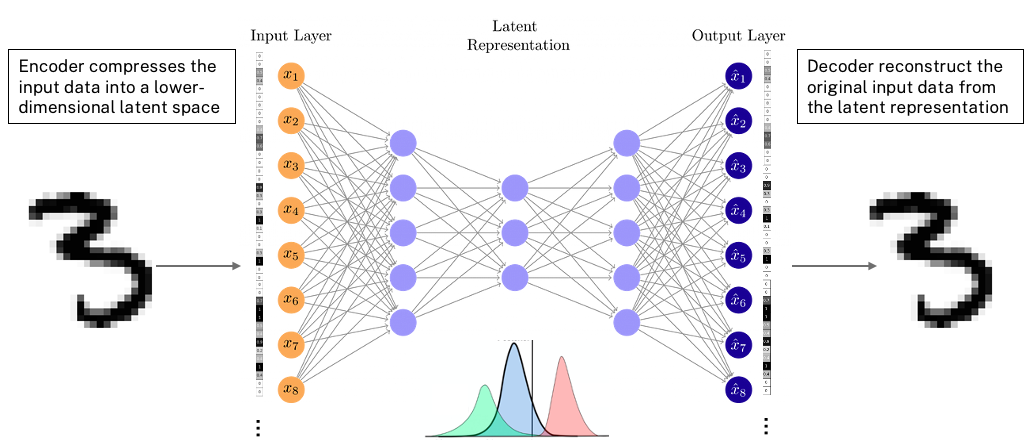

## Useful packages

In [ ]:
# Let's work within our working directory, e.g., where MNIST data is stored
import os
os.chdir('/home/563/yq5547/notebooks/ASTR4004')

# We need numpy to handle data and array
import numpy as np

# We need matplotlib.pyplot to make plots
import matplotlib.pyplot as plt

# tensorflow and its keras API provide a NN framework
import tensorflow as tf
# Set the number of threads for intra and inter operations
tf.config.threading.set_intra_op_parallelism_threads(13)  # Set to your desired number
tf.config.threading.set_inter_op_parallelism_threads(13)

from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Lambda

# set hyperparameters at the beginning
l_rate = 1e-4
Nepoch = 100
batch_size = 64

## Dataset preparation
MNIST contains 70,000 images of handwritten digits, in greyscale with pixel-values from 0 to 255. Let us first load the data. I have store them in two seperated numpy files. But we only need the images here. Label is not needed.

In [ ]:
# load data
images = np.load('./MNIST_images.npy', allow_pickle=True)
labels = np.load('./MNIST_labels.npy', allow_pickle=True)

# it is normally a good practice to rescale the training data into [0, 1] or [-1, 1]
images = (images - np.min(images)) / (np.max(images) - np.min(images))

# flatten images into 1D array
x = images.reshape([len(images), -1])

### Let's divide the sample into training (90%) and test (10%) 

In [ ]:
train_size = int(0.9 * len(x)) # tensorflow can split some from training set for validation
test_size = len(x) - train_size

x_train, x_test = x[:train_size], x[test_size:]
images_test = images[test_size:]
labels_train = labels[:train_size]

print("Training data: {}".format(x_train.shape))
print("Test data: {}".format(x_test.shape))

### It is often a good practice to reshuffle the training set to get rid of any existing pattern in the data

In [ ]:
shuffle_index = np.random.permutation(train_size)
x_train = x_train[shuffle_index]
labels_train = labels_train[shuffle_index]

shuffle_index = np.random.permutation(test_size)
x_test = x_test[shuffle_index]
images_test = images_test[shuffle_index]

## Network definition

In [ ]:
input_dim = 28*28
hidden_dim = 512
latent_dim = 128
AE = 'VAE' #or 'CAE'

if AE == 'CAE': # Conventional Autoencoder
    encoder_input = Input(shape=(input_dim,))
    ...
    encoder = ...
    
else: # Variational Autoencoder
    encoder_input  = Input(shape=(input_dim,))
    ...
    encoder = ...

...
decoder = ...

inputs  = Input(shape=(input_dim,))
latent  = encoder(inputs)
outputs = decoder(latent)
ae      = Model(inputs, outputs)

Use the (untrained) autoencoder to create an image.

In [ ]:
# Visualize generated images to see the training progress
...

plt.figure(figsize=(5, 2))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_images[i].numpy().reshape([28,28]), cmap='gray')
    plt.axis('off')
plt.subplots_adjust(wspace=0.02,hspace=0.02)       

## Network training

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(l_rate)
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

for epoch in range(Nepoch):
    for x in train_dataset:
             
        with tf.GradientTape() as tape:
        
            reconstructed = ae(x)
            
            loss = loss_fn(x, reconstructed)
                   
        grads = tape.gradient(loss, ae.trainable_variables)
        optimizer.apply_gradients(zip(grads, ae.trainable_variables))
        
    # Visualize generated images to see the training progress
    if epoch%10 == 0:    
        print(f'Epoch {epoch+1}/{Nepoch}, Loss: {loss.numpy():.4f}')
        
        latent_samples = tf.random.normal(shape=(10, latent_dim))
        generated_images = decoder(latent_samples)    
        plt.figure(figsize=(5, 2))
        for i in range(10):
            plt.subplot(2, 5, i + 1)
            plt.imshow(generated_images[i].numpy().reshape([28,28]), cmap='gray')
            plt.axis('off')
        plt.subplots_adjust(wspace=0.02,hspace=0.02)       

## Latent Space Visualization

In [ ]:
from sklearn.decomposition import PCA

# Assuming x_train and y_train are already defined and encoder is trained
latent_vectors = encoder(x_train).numpy()

# Use PCA for dimensionality reduction
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

# Plotting latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], 
                      c=labels_train.astype('int'), 
                      cmap='viridis', alpha=0.7, s=0.1)
plt.colorbar(scatter)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.grid(True)
plt.show()